In [2]:
import os
import argparse
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader

Data shape: (629,)


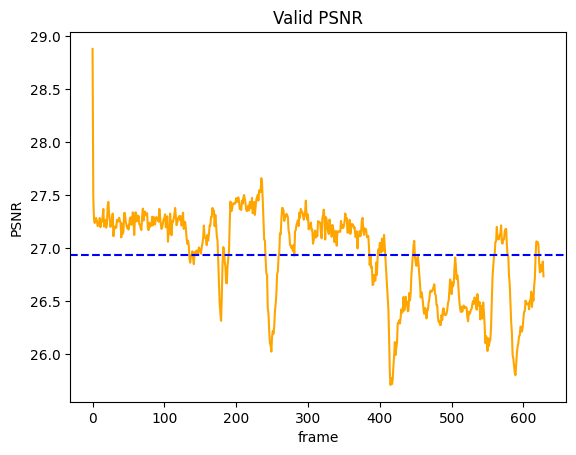

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 載入 .npy 檔案
file_path1 = "../valid_PSNR/Without_0.npy"
data1 = np.load(file_path1)
# 檢查數據的形狀
print("Data shape:", data1.shape)
mean_value = np.mean(data1)

# 畫圖
plt.plot(data1,color='orange')
plt.title('Valid PSNR')
plt.xlabel('frame',)
plt.ylabel('PSNR')
plt.axhline(y=mean_value, color='blue', linestyle='--', label=f'Mean PSNR: {mean_value:.2f}')
plt.show()

In [13]:
def frange_cycle_linear(num_epoch, start=0.0, stop=1.0, n_cycle=1, ratio=1):
    L = np.ones(num_epoch + 1)
    period = num_epoch / n_cycle
    step = (stop - start) / (period * ratio)

    for c in range(n_cycle):
        v, i = start, 0
        while v <= stop and (int(i + c * period) < num_epoch):
            L[int(i + c * period)] = v
            v += step
            i += 1
    return L

# 設定參數
num_epoch = 30
start = 0.0
stop = 1.0
n_cycle = 1
ratio = 0.5
L = frange_cycle_linear(num_epoch, start, stop, n_cycle, ratio)
L


array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
       0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
       0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

In [2]:
import os
os.makedirs("save_path", exist_ok=True)

In [7]:

filename = os.path.basename('train_img/020001.img')
filename = filename.split('.')[0].replace('frame', '')
int(filename)


20001

In [ ]:
import os
import argparse
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader

from modules import Generator, Gaussian_Predictor, Decoder_Fusion, Label_Encoder, RGB_Encoder

from dataloader import Dataset_Dance
from torchvision.utils import save_image
import random
import torch.optim as optim
from torch import stack

from tqdm import tqdm
import imageio
from torch.utils import tensorboard
import matplotlib.pyplot as plt
from math import log10

def Generate_PSNR(imgs1, imgs2, data_range=1.):
    """PSNR for torch tensor"""
    mse = nn.functional.mse_loss(imgs1, imgs2) # wrong computation for batch size > 1
    psnr = 20 * log10(data_range) - 10 * torch.log10(mse)
    return psnr


def kl_criterion(mu, logvar, batch_size):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD /= batch_size  
    return KLD


class kl_annealing():
    def __init__(self, args, current_epoch=0):
        # TODO
        self.iteration = current_epoch + 1
        self.kl_anneal_type = args.kl_anneal_type

        if (self.kl_anneal_type == "Cyclical"):
            self.KLlist = self.frange_cycle_linear(n_iter = args.num_epoch , start = 0.0 , stop = 1.0 , n_cycle= args.kl_anneal_cycle , ratio = args.kl_anneal_ratio)
        elif (self.kl_anneal_type == "Monotonic"):
            self.KLlist = self.frange_cycle_linear(n_iter= args.num_epoch ,start=0.0 , stop = 1.0 , n_cycle = 1 ,ratio =args.kl_anneal_ratio )
        else:
            self.KLlist = np.ones(args.num_epoch + 1)
        #raise NotImplementedError
        
    def update(self):
        # TODO
        self.iteration +=1
        #raise NotImplementedError
    
    def get_beta(self):
        # TODO
        return self.KLlist[self.iteration]
        #raise NotImplementedError

    def frange_cycle_linear(self, n_iter, start=0.0, stop=1.0,  n_cycle=1, ratio=1):
        # TODO
        KLlist = np.ones(n_iter + 1)
        period = n_iter / n_cycle
        step = (stop-start) / (period*ratio)

        for c in range(n_cycle):
            v = start
            i = 0
            while v <= stop and (int(i + c * period) < n_iter):
                KLlist[int(i+c*period)] = v
                v += step
                i += 1
        return KLlist
        #cite from paper code
        #raise NotImplementedError
        

class VAE_Model(nn.Module):
    def __init__(self, args):
        super(VAE_Model, self).__init__()
        self.args = args
        self.savestatus = tensorboard.SummaryWriter(f"logs/KLtype_{args.kl_anneal_type}_TeacherForceRatio_{args.tfr}_TeacherDecay_{args.tfr_d_step}")
        
        # Modules to transform image from RGB-domain to feature-domain
        self.frame_transformation = RGB_Encoder(3, args.F_dim)
        self.label_transformation = Label_Encoder(3, args.L_dim)
        
        # Conduct Posterior prediction in Encoder
        self.Gaussian_Predictor   = Gaussian_Predictor(args.F_dim + args.L_dim, args.N_dim)
        self.Decoder_Fusion       = Decoder_Fusion(args.F_dim + args.L_dim + args.N_dim, args.D_out_dim)
        
        # Generative model
        self.Generator            = Generator(input_nc=args.D_out_dim, output_nc=3)
        
        self.optim      = optim.Adam(self.parameters(), lr=self.args.lr)
        self.scheduler  = optim.lr_scheduler.MultiStepLR(self.optim, milestones=[2, 5], gamma=0.1) #[2,4]
        self.kl_annealing = kl_annealing(args, current_epoch=0)
        self.mse_criterion = nn.MSELoss()
        self.current_epoch = 0
        
        # Teacher forcing arguments
        self.tfr = args.tfr
        self.tfr_d_step = args.tfr_d_step
        self.tfr_sde = args.tfr_sde
        
        self.train_vi_len = args.train_vi_len
        self.val_vi_len   = args.val_vi_len
        self.batch_size = args.batch_size
        
        
    def forward(self, img, label):
        pass
    
    def training_stage(self):
        for i in range(self.args.num_epoch):
            train_loader = self.train_dataloader()
            adapt_TeacherForcing = True if random.random() < self.tfr else False
            train_loss = []

            for (img, label) in (pbar := tqdm(train_loader, ncols=120)):
                img = img.to(self.args.device)
                label = label.to(self.args.device)
                loss = self.training_one_step(img, label, adapt_TeacherForcing)
                
                beta = self.kl_annealing.get_beta()
                train_loss.append(loss.detach().cpu())
                if adapt_TeacherForcing:
                    self.tqdm_bar('train [TeacherForcing: ON, {:.1f}], beta: {}'.format(self.tfr, beta), pbar, loss.detach().cpu(), lr=self.scheduler.get_last_lr()[0])
                else:
                    self.tqdm_bar('train [TeacherForcing: OFF, {:.1f}], beta: {}'.format(self.tfr, beta), pbar, loss.detach().cpu(), lr=self.scheduler.get_last_lr()[0])
            
            if self.current_epoch % self.args.per_save == 0:
                self.save(os.path.join(self.args.save_root, f"epoch={self.current_epoch}.ckpt"))
                
        
            self.eval()
            self.current_epoch += 1
            self.scheduler.step()
            self.teacher_forcing_ratio_update()
            self.kl_annealing.update()
            self.writer.add_scalar('loss/train', np.mean(train_loss), self.current_epoch)
            self.writer.add_scalar('tfr', self.tfr, self.current_epoch)
            self.writer.add_scalar('beta', beta, self.current_epoch)
            
            
    @torch.no_grad()
    def eval(self):
        val_loader = self.val_dataloader()
        val_loss = []
        psnr = []
        for (img, label) in (pbar := tqdm(val_loader, ncols=120)):
            img = img.to(self.args.device)
            label = label.to(self.args.device)
            loss , psnr_return = self.val_one_step(img, label)
            self.tqdm_bar('val', pbar, loss.detach().cpu(), lr=self.scheduler.get_last_lr()[0])
            val_loss.append(loss.detach().cpu())
            psnr.append(psnr_return)
        val_loss_mean = np.mean(val_loss)
        psnr_mean = np.mean(psnr)
        self.savestatus.add_scalar('loss/validation',val_loss_mean , self.current_epoch)
        self.savestatus.add_scalar('PSNR/validation',psnr_mean , self.current_epoch)
    
    def training_one_step(self, img, label, adapt_TeacherForcing):
        # TODO
        
        batch_size = img.shape[0] # batch_size is 2 as default
        losses = 0
        beta = self.kl_annealing.get_beta()
        
        for idx in range(batch_size):
            img = img[idx]
            label = label[idx]
            x_gt = img[0].unsqueeze(0)
            KLdiver = 0
            mseloss = 0
            for time in range(0 , img.size(0)-1):
                img_encoder_out = self.frame_transformation(img[time+1].unsqueeze(0))
                label_encoder_out = self.frame_transformation(label[time+1].unsqueeze(0))

                z, mu, logvar = self.Gaussian_Predictor(img_encoder_out , label_encoder_out)

                img_prev = img[time].squeeze(0) if adapt_TeacherForcing else x_gt 
                img_prev_encoder = self.frame_transformation(img_prev).detach()
                decoder_out = self.Decoder_Fusion(img_prev_encoder , label_encoder_out , z)
                x_gt = self.Generator(decoder_out)

                mseloss += self.mse_criterion(x_gt ,img[time+1].unsqueeze(0) )
                KLdiver += kl_criterion(mu=mu , logvar = logvar , batch_size=batch_size)

            self.optim.zero_grad()
            train_loss = mseloss + beta * KLdiver
            train_loss.backward()
            self.optimizer_step()
            losses += train_loss

        losses = losses / batch_size
        return losses
        #傳入img: (Batch_size,Time_step,Channel,Height,Width)=(2,16,3,32,64)
        #raise NotImplementedError
    
    def val_one_step(self, img, label):
        # TODO
        batch_size = img.shape[0] # batch_size is 2 as default
        losses = 0
        psnr_list = []
        beta = self.kl_annealing.get_beta()
        for idx in range(batch_size):
            img = img[idx]
            label = label[idx]
            x_gt = img[0].unsqueeze(0)
            KLdiver = 0
            mseloss = 0
            for time in range(0 , img.size(0)-1):
                img_encoder_out = self.frame_transformation(img[time+1].unsqueeze(0))
                label_encoder_out = self.frame_transformation(label[time+1].unsueeze(0))

                z, mu, logvar = self.Gaussian_Predictor(img_encoder_out , label_encoder_out)

                img_prev = x_gt.detach() 
                img_prev_encoder = self.frame_transformation(img_prev).detach()
                decoder_out = self.Decoder_Fusion(img_prev_encoder , label_encoder_out , z)
                x_gt = self.Generator(decoder_out)

                mseloss += self.mse_criterion(x_gt ,img[time+1].unsqueeze(0))
                KLdiver += kl_criterion(mu=mu , logvar = logvar , batch_size=batch_size)
                psnr_list.append(Generate_PSNR(img[time+1].unsqueeze(0) , x_gt))
            valid_loss = mseloss + beta * KLdiver
            losses+=valid_loss

        losses = losses / batch_size
        return losses , np.mean(psnr_list)
        #raise NotImplementedError
                
    def make_gif(self, images_list, img_name):
        new_list = []
        for img in images_list:
            new_list.append(transforms.ToPILImage()(img))
            
        new_list[0].save(img_name, format="GIF", append_images=new_list,
                    save_all=True, duration=40, loop=0)
    
    def train_dataloader(self):
        transform = transforms.Compose([
            transforms.Resize((self.args.frame_H, self.args.frame_W)),
            transforms.ToTensor()
        ])

        dataset = Dataset_Dance(root=self.args.DR, transform=transform, mode='train', video_len=self.train_vi_len, \
                                                partial=args.fast_partial if self.args.fast_train else args.partial)
        if self.current_epoch > self.args.fast_train_epoch:
            self.args.fast_train = False
            
        train_loader = DataLoader(dataset,
                                  batch_size=self.batch_size,
                                  num_workers=self.args.num_workers,
                                  drop_last=True,
                                  shuffle=False)  
        return train_loader
    
    def val_dataloader(self):
        transform = transforms.Compose([
            transforms.Resize((self.args.frame_H, self.args.frame_W)),
            transforms.ToTensor()
        ])
        dataset = Dataset_Dance(root=self.args.DR, transform=transform, mode='val', video_len=self.val_vi_len, partial=1.0)  
        val_loader = DataLoader(dataset,
                                  batch_size=1,
                                  num_workers=self.args.num_workers,
                                  drop_last=True,
                                  shuffle=False)  
        return val_loader
    
    def teacher_forcing_ratio_update(self):
        # TODO
        if self.current_epoch % self.tfr_sde == 0:
            if self.current_epoch >= self.tfr_sde :
                self.tfr = max(self.tfr-self.tfr_d_step, 0)
        #raise NotImplementedError
            
    def tqdm_bar(self, mode, pbar, loss, lr):
        pbar.set_description(f"({mode}) Epoch {self.current_epoch}, lr:{lr}" , refresh=False)
        pbar.set_postfix(loss=float(loss), refresh=False)
        pbar.refresh()
        
    def save(self, path):
        torch.save({
            "state_dict": self.state_dict(),
            "optimizer": self.state_dict(),  
            "lr"        : self.scheduler.get_last_lr()[0],
            "tfr"       :   self.tfr,
            "last_epoch": self.current_epoch
        }, path)
        print(f"save ckpt to {path}")

    def load_checkpoint(self):
        if self.args.ckpt_path != None:
            checkpoint = torch.load(self.args.ckpt_path)
            self.load_state_dict(checkpoint['state_dict'], strict=True) 
            self.args.lr = checkpoint['lr']
            self.tfr = checkpoint['tfr']
            
            self.optim      = optim.Adam(self.parameters(), lr=self.args.lr)
            self.scheduler  = optim.lr_scheduler.MultiStepLR(self.optim, milestones=[2, 4], gamma=0.1)
            self.kl_annealing = kl_annealing(self.args, current_epoch=checkpoint['last_epoch'])
            self.current_epoch = checkpoint['last_epoch']

    def optimizer_step(self):
        nn.utils.clip_grad_norm_(self.parameters(), 1.)
        self.optim.step()



def main(args):
    
    os.makedirs(args.save_root, exist_ok=True)
    model = VAE_Model(args).to(args.device)
    model.load_checkpoint()
    if args.test:
        model.eval()
    else:
        model.training_stage()




if __name__ == '__main__':
    parser = argparse.ArgumentParser(add_help=True)
    parser.add_argument('--batch_size',    type=int,    default=2)
    parser.add_argument('--lr',            type=float,  default=0.001,     help="initial learning rate")
    parser.add_argument('--device',        type=str, choices=["cuda", "cpu"], default="cuda")
    parser.add_argument('--optim',         type=str, choices=["Adam", "AdamW"], default="Adam")
    parser.add_argument('--gpu',           type=int, default=1)
    parser.add_argument('--test',          action='store_true')
    parser.add_argument('--store_visualization',      action='store_true', help="If you want to see the result while training")
    parser.add_argument('--DR',            type=str, required=True,  help="Your Dataset Path")
    parser.add_argument('--save_root',     type=str, required=True,  help="The path to save your data")
    parser.add_argument('--num_workers',   type=int, default=4)
    parser.add_argument('--num_epoch',     type=int, default=70,     help="number of total epoch")
    parser.add_argument('--per_save',      type=int, default=3,      help="Save checkpoint every seted epoch")
    parser.add_argument('--partial',       type=float, default=1.0,  help="Part of the training dataset to be trained")
    parser.add_argument('--train_vi_len',  type=int, default=16,     help="Training video length")
    parser.add_argument('--val_vi_len',    type=int, default=630,    help="valdation video length")
    parser.add_argument('--frame_H',       type=int, default=32,     help="Height input image to be resize")
    parser.add_argument('--frame_W',       type=int, default=64,     help="Width input image to be resize")
    
    
    # Module parameters setting
    parser.add_argument('--F_dim',         type=int, default=128,    help="Dimension of feature human frame")
    parser.add_argument('--L_dim',         type=int, default=32,     help="Dimension of feature label frame")
    parser.add_argument('--N_dim',         type=int, default=12,     help="Dimension of the Noise")
    parser.add_argument('--D_out_dim',     type=int, default=192,    help="Dimension of the output in Decoder_Fusion")
    
    # Teacher Forcing strategy
    parser.add_argument('--tfr',           type=float, default=1.0,  help="The initial teacher forcing ratio")
    parser.add_argument('--tfr_sde',       type=int,   default=10,   help="The epoch that teacher forcing ratio start to decay")
    parser.add_argument('--tfr_d_step',    type=float, default=0.1,  help="Decay step that teacher forcing ratio adopted")
    parser.add_argument('--ckpt_path',     type=str,    default=None,help="The path of your checkpoints")   
    
    # Training Strategy
    parser.add_argument('--fast_train',         action='store_true')
    parser.add_argument('--fast_partial',       type=float, default=0.4,    help="Use part of the training data to fasten the convergence")
    parser.add_argument('--fast_train_epoch',   type=int, default=5,        help="Number of epoch to use fast train mode")
    
    # Kl annealing stratedy arguments
    parser.add_argument('--kl_anneal_type',     type=str, default='Cyclical',choices=["Cyclical" , "Monotonic" , "Without KL"]   ,help="")
    parser.add_argument('--kl_anneal_cycle',    type=int, default=10,               help="")
    parser.add_argument('--kl_anneal_ratio',    type=float, default=1,              help="")
    

    

    args = parser.parse_args()
    
    main(args)
